## Implementacja "Robust global stabilization and disturbance rejection of an underactuated nonholonomic airship"

Link do implementowanego artykułu: https://ieeexplore.ieee.org/document/4389345

# Import

In [104]:
import sympy as sp
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt # ploting results
from scipy.integrate import solve_ivp # solving differential equations
MAT = np.array

# Definicja zmiennych

In [105]:
t = sp.symbols('t') # czas
th = sp.symbols('\\theta') # kąt obrotu sterowca w układzie globalnym
u = sp.symbols('u') # prędkość wzdłużna sterowca w układzie lokalnym
v = sp.symbols('v') # prędkość poprzeczna sterowca w układzie lokalnym
r = sp.symbols('r') # prędkość obrotowa sterowca w układzie globalnym
x, y = sp.symbols('x y') # położenie sterowca w układzie globalnym
z1, z2, z3 = sp.symbols('z_{1} z_{2} z_{3}') # ?
tauu, taur = sp.symbols('\\tau_{u} \\tau_{r}') # sygnały sterujące kolejno: siła ciągu, siła skręcająca 
ub, vb, z1b, z2b, z3b = sp.symbols('\\bar{u} \\bar{v} \\bar{z}_{1} \\bar{z}_{2} \\bar{z}_{3}')#nowe zmienne stanu po transforma
#u, v, z1, z2, z3, r, th = u_(t), v_(t), z1_(t), z2_(t), z3_(t), r_(t), th_(t)

# Współczynniki

In [106]:
Cu, Cv, Cr = sp.symbols('C_{u} C_{v} C_{r}') #współczynniki aerodynamiczne względem osi u v r
Vw = sp.symbols('V_{w}') #prędkość wiatru (w artykule jest zawsze stała)
a_ship, b_ship = sp.symbols('a_{ship} b_{ship}') #długość sterowca, szerokość sterowca
m, m3 = sp.symbols('m m_{3}') # masa strowca m=m1=m2, masa sterowca m3------------------------------------
d1, d2, d3 = sp.symbols('d_{1} d_{2} d_{3}') # współczynniki tłumienia kolejno w osi u v r
d1f, d2f, d3f, th3f = sp.symbols('\\underline{d}_{1} \\underline{d}_{2} \\underline{d}_{3} \\underline{\\theta}_{3}') # dolne wartości wsp tłumienia d1, d2, d3
d1c, d2c, d3c, th3c = sp.symbols('\\bar{d}_{1} \\bar{d}_{2} \\bar{d}_{3} \\bar{\\theta}_{3}') # górne wartości współczynników tłumienia d1, d2, d3
d10, d20, d30, th30 = sp.symbols('d_{10} d_{20} d_{30} \\theta_{30}') # niepewności
Delta_1, Delta_2, Delta_3, delta_1, delta_2, delta_3 = sp.symbols('\\Delta_{1} \\Delta_{2} \\Delta_{3} \\delta_{1} \\delta_{2} \\delta_{3}')# niepewności
k1, k2, k3, a = sp.symbols('k_{1} k_{2} k_{3} a') # współczynniki wzmocnień syg ster tau_r
k_th, k_r  = sp.symbols('k_{\\theta} k_{r}') # jak wyżej
k1b, k2b, k3b, k4b, k5b = sp.symbols('\\bar{k}_{1} \\bar{k}_{2} \\bar{k}_{3} \\bar{k}_{4} \\bar{k}_{5}')#wsp wzm sterownika tau_u
th_1, th_2, th_3 = sp.symbols('\\theta_1 \\theta_2 \\theta_3') # współczynniki th z obliczone na podst wzoru 4.4
lam_1, lam_2 = sp.symbols('\lambda_1 \lambda_2') # współczynniki lam z obliczone na podst wzoru 4.4
delta_d = sp.symbols('\\Delta_{d}') # współczynnik deltad ze wzoru 4.3
th_0, r_0 = sp.symbols('th(0) r(0)')# wartości początkowe
fu, fv, fr = sp.symbols('f_{u} f_{v} f_{r}') # funkcje symboliczne

Definicja funkcji - rozdział II (2.2)

In [107]:
F = sp.sqrt(a_ship**2 * sp.sin(th)**2 + b_ship**2 * sp.cos(th)**2)
display(F)

sqrt(a_{ship}**2*sin(\theta)**2 + b_{ship}**2*cos(\theta)**2)

Opis modelu kinematycznego, geometrycznego powiązania pomiędzy układem globalnym a układem lokalnym - rozdział II (2.4)

In [108]:
dx = u * sp.cos(th) - v * sp.sin(th)
dy = u * sp.sin(th) + v * sp.cos(th)
dth = r
display(dx,dy,dth)

u*cos(\theta) - v*sin(\theta)

u*sin(\theta) + v*cos(\theta)

r

Ciąg dalszy opisu kinematyki, z1 z2 - rozdział II (2.5)

In [109]:
z1_ = x * sp.cos(th) + y * sp.sin(th)
z2_ = -x * sp.sin(th) + y * sp.cos(th)
#wyświetlanie implementowanych wzorów
display(z1_,z2_)

x*cos(\theta) + y*sin(\theta)

-x*sin(\theta) + y*cos(\theta)

Równanie stanu uzyskane przez połączenie kinematyki i dynamiki sterowca - rozdział II (2.6)

In [110]:
# układ Sigma1:
# macierz stanu
A1 = sp.Matrix([[-d1,r,0,0],[-r,-d2,0,0],[1,0,0,r],[0,1,-r,0]])  
#---------
q = sp.Matrix([[u,v,z1,z2]]).T # wektor stanu
b1 = sp.Matrix([[1/m,0,0,0]]).T # macierz sterowania
# wektor sił zakłóceń - wiatru
f1 = sp.Matrix([[fu/m,fv/m,0,0]]).T 
#wyświetlanie implementowanych wzorów
display(A1,q,b1,f1)

Matrix([
[-d_{1},      r,  0, 0],
[    -r, -d_{2},  0, 0],
[     1,      0,  0, r],
[     0,      1, -r, 0]])

Matrix([
[    u],
[    v],
[z_{1}],
[z_{2}]])

Matrix([
[1/m],
[  0],
[  0],
[  0]])

Matrix([
[f_{u}/m],
[f_{v}/m],
[      0],
[      0]])

In [111]:
# układ Sigma2:                                    #ten układ umieścić w funkcji symulacji
dr = -d3 * r + (1/m3) * (taur + fr) 
dth = r
display(dr,dth)

-d_{3}*r + (\tau_{r} + f_{r})/m_{3}

r

Sygnał sterujący dla podsystemu Sigma2 - rozdział IV (4.1)

In [112]:
taur = m3 * (-k_r * r - k_th * th + a * sp.exp(-k3 * t) - fr) 
display(taur)

m_{3}*(-\theta*k_{\theta} + a*exp(-k_{3}*t) - f_{r} - k_{r}*r)

Odpowiedź kąta i prędkości kątowej jest dana - rozdział IV (4.3)

In [113]:
Th = th_1*sp.exp(-lam_1*t) + th_2*sp.exp(-lam_2*t) + th_3*sp.exp(-k3*t) # th(t)
R = -th_1*lam_1*sp.exp(-lam_1*t) - th_2*lam_2*sp.exp(-lam_2*t) - th_3*k3*sp.exp(-k3*t) # r(t)
tta, rf = sp.symbols('\\theta(t) r(t)') # to będą później funkcje te powyżej
display(Th,R)

\theta_1*exp(-\lambda_1*t) + \theta_2*exp(-\lambda_2*t) + \theta_3*exp(-k_{3}*t)

-\lambda_1*\theta_1*exp(-\lambda_1*t) - \lambda_2*\theta_2*exp(-\lambda_2*t) - \theta_3*k_{3}*exp(-k_{3}*t)

Funkcja alpha(t) - rozdział IV (4.14)

In [114]:
Alp = -(th_1*lam_1*sp.exp(-(lam_1-k3)*t)+th_2*lam_2*sp.exp(-(lam_2-k3)*t)) #funkcja alpha(t)
display(Alp)

-\lambda_1*\theta_1*exp(t*(-\lambda_1 + k_{3})) - \lambda_2*\theta_2*exp(t*(-\lambda_2 + k_{3}))

Implementacja współczynników theta - rozdział IV (4.4)

In [115]:
th_1 = ((lam_2*th_0 + r_0)/(lam_2 - lam_1)) + a/((lam_2 - lam_1)*(k3 - lam_1))
th_2 = ((k1*th_0 + r_0)/(lam_1 - lam_2)) + a/((lam_1 - lam_2)*(k3 - lam_2))
th_3 = a/((lam_1 - k3)*(lam_2 - k3))
#wyświetlanie implementowanych wzorów
display(th_1,th_2,th_3)  

a/((-\lambda_1 + \lambda_2)*(-\lambda_1 + k_{3})) + (\lambda_2*th(0) + r(0))/(-\lambda_1 + \lambda_2)

a/((\lambda_1 - \lambda_2)*(-\lambda_2 + k_{3})) + (k_{1}*th(0) + r(0))/(\lambda_1 - \lambda_2)

a/((\lambda_1 - k_{3})*(\lambda_2 - k_{3}))

Implementacja współczynników lambda - rozdział IV (4.4)

In [116]:
lam_1 = ((delta_d + k1 + k2) + sp.sqrt(delta_d**2 + 2*delta_d*(k1 + k2) + (k1 - k2)**2))/2#
lam_2 = ((delta_d + k1 + k2) - sp.sqrt(delta_d**2 + 2*delta_d*(k1 + k2) + (k1 - k2)**2))/2#
delta_d = d3 - d3f#
#wyświetlanie implementowanych wzorów
display(lam_1,lam_2,delta_d)

\Delta_{d}/2 + k_{1}/2 + k_{2}/2 + sqrt(\Delta_{d}**2 + 2*\Delta_{d}*(k_{1} + k_{2}) + (k_{1} - k_{2})**2)/2

\Delta_{d}/2 + k_{1}/2 + k_{2}/2 - sqrt(\Delta_{d}**2 + 2*\Delta_{d}*(k_{1} + k_{2}) + (k_{1} - k_{2})**2)/2

-\underline{d}_{3} + d_{3}

Implementacja systemu Sigma1e - rozdział IV (4.7)

In [117]:
A2 = sp.Matrix([[-d1,rf,0,0,0],[-rf,-d2,0,0,0],[1,0,0,rf,0],[0,1,-rf,0,0],[0,0,1,0,0]])# macierz stanu
b2 = sp.Matrix([[1/m,0,0,0,0]]).T # macierz sterowania
ff = sp.Matrix([[fu/m,-fv/m,0,0,0]]).T # wektor zakłóceń - wiatru
q2 = sp.Matrix([[u,v,z1,z2,z3]]).T # wektor stanu
display(A2,b2,ff,q2)
#display(dX1_sym)

Matrix([
[-d_{1},   r(t),     0,    0, 0],
[ -r(t), -d_{2},     0,    0, 0],
[     1,      0,     0, r(t), 0],
[     0,      1, -r(t),    0, 0],
[     0,      0,     1,    0, 0]])

Matrix([
[1/m],
[  0],
[  0],
[  0],
[  0]])

Matrix([
[ f_{u}/m],
[-f_{v}/m],
[       0],
[       0],
[       0]])

Matrix([
[    u],
[    v],
[z_{1}],
[z_{2}],
[z_{3}]])

Definicja funkcji - rozdział II (2.2)

In [118]:
fu = Cu * Vw**2 * F * sp.cos(th)
fv = Cv * Vw**2 * F * sp.sin(th)
fr = Cr * Vw**2 * F * sp.cos(2 * th)
display(fu,fv,fr) 

C_{u}*V_{w}**2*sqrt(a_{ship}**2*sin(\theta)**2 + b_{ship}**2*cos(\theta)**2)*cos(\theta)

C_{v}*V_{w}**2*sqrt(a_{ship}**2*sin(\theta)**2 + b_{ship}**2*cos(\theta)**2)*sin(\theta)

C_{r}*V_{w}**2*sqrt(a_{ship}**2*sin(\theta)**2 + b_{ship}**2*cos(\theta)**2)*cos(2*\theta)

Nowy wektor stanu - rozdział IV (4.10)

In [119]:
ub = u
vb = v * sp.exp(-k3 * t)
z1b = z1
z2b = z2 * sp.exp(-k3 * t)
z3b = z3
Xb = sp.Matrix([[ub,vb,z1b,z2b,z3b]]).T
#wyświetlanie implementowanych wzorów
display(Xb)

Matrix([
[                  u],
[    v*exp(-k_{3}*t)],
[              z_{1}],
[z_{2}*exp(-k_{3}*t)],
[              z_{3}]])

Współczynniki d1, d2, th3 - rozdział IV (4.11)

In [120]:
d1 = d10 + Delta_1#
d2 = d20 + Delta_2#
d3 = d30 + Delta_3# za d3 podstawić ręcznie wartość z artykułu 0.05
th3 = th30 + Delta_3#
#wyświetlanie implementowanych wzorów
display(d1,d2,d3,th3)

\Delta_{1} + d_{10}

\Delta_{2} + d_{20}

\Delta_{3} + d_{30}

\Delta_{3} + \theta_{30}

Rozszerzony system Sigma1e bez zakłócenia f(t) - rozdział IV (4.13) i (4.14)

In [121]:
#macierze o stałych współczynnikach
A10 = sp.Matrix([[-d10,0,0,0,0],[th30*k3,-(d20-k3),0,0,0],[1,0,0,0,0],[0,1,th30*k3,k3,0],[0,0,1,0,0]])#
D = sp.Matrix([[1,0,0,0],[0,1,1,0],[0,0,0,0],[0,0,0,1],[0,0,0,0]])#
E = sp.Matrix([[-delta_1,0,0,0,0],[0,-delta_2,0,0,0],[k3*delta_3,0,0,0,0],[0,0,k3*delta_3,0,0]])#
DELTA = sp.Matrix.diag([Delta_1/delta_1,Delta_2/delta_2,Delta_3/delta_3,Delta_3/delta_3])#
#macierz o zmiennych współczynnikach
af = sp.symbols('\\alpha(t)')# to będzie później funkcja alpha(t)
A22 = sp.Matrix([[0,rf*sp.exp(-k3*t),0,0,0],[af,0,0,0,0],[0,0,0,rf*sp.exp(-k3*t),0],[0,0,af,0,0],[0,0,0,0,0]])
#wyświetlanie implementowanych wzorów
display(A22)
display(A10,D,E,DELTA)

Matrix([
[        0, r(t)*exp(-k_{3}*t),         0,                  0, 0],
[\alpha(t),                  0,         0,                  0, 0],
[        0,                  0,         0, r(t)*exp(-k_{3}*t), 0],
[        0,                  0, \alpha(t),                  0, 0],
[        0,                  0,         0,                  0, 0]])

Matrix([
[          -d_{10},               0,                 0,     0, 0],
[\theta_{30}*k_{3}, -d_{20} + k_{3},                 0,     0, 0],
[                1,               0,                 0,     0, 0],
[                0,               1, \theta_{30}*k_{3}, k_{3}, 0],
[                0,               0,                 1,     0, 0]])

Matrix([
[1, 0, 0, 0],
[0, 1, 1, 0],
[0, 0, 0, 0],
[0, 0, 0, 1],
[0, 0, 0, 0]])

Matrix([
[     -\delta_{1},           0,                0, 0, 0],
[               0, -\delta_{2},                0, 0, 0],
[\delta_{3}*k_{3},           0,                0, 0, 0],
[               0,           0, \delta_{3}*k_{3}, 0, 0]])

Matrix([
[\Delta_{1}/\delta_{1},                     0,                     0,                     0],
[                    0, \Delta_{2}/\delta_{2},                     0,                     0],
[                    0,                     0, \Delta_{3}/\delta_{3},                     0],
[                    0,                     0,                     0, \Delta_{3}/\delta_{3}]])

Wzory potrzebne do obliczenia d1, d2, th3 - rozdział IV (4.12)

In [122]:
delta_3 = (th3c - th3f)/2 #
th30 = (th3c + th3f)/2 #
display(delta_3,th30)

\bar{\theta}_{3}/2 - \underline{\theta}_{3}/2

\bar{\theta}_{3}/2 + \underline{\theta}_{3}/2

In [123]:
th3f = a/((k3 - k1)*(k3 - k2))#
th3c = a/(k3**2 - (d3c + k_r)*k3 + k1*k2)#
d10 = (d1c + d1f)/2#
d20 = (d2c + d2f)/2#
d30 = (d3c + d3f)/2#
delta_1 = (d1c - d1f)/2#
delta_2 = (d2c - d2f)/2#
#wyświetlanie implementowanych wzorów
display(th3f,th3c,d10,d20,d30,delta_1,delta_2)

a/((-k_{1} + k_{3})*(-k_{2} + k_{3}))

a/(k_{1}*k_{2} + k_{3}**2 - k_{3}*(\bar{d}_{3} + k_{r}))

\bar{d}_{1}/2 + \underline{d}_{1}/2

\bar{d}_{2}/2 + \underline{d}_{2}/2

\bar{d}_{3}/2 + \underline{d}_{3}/2

\bar{d}_{1}/2 - \underline{d}_{1}/2

\bar{d}_{2}/2 - \underline{d}_{2}/2

Sygnał sterujący tau_u - rozdział IV (4.21)

In [124]:
tauu = -(k1b*u+k2b*v*sp.exp(-k3*t)+k3b*z1+k4b*z2*sp.exp(-k3*t)+k5b*z3)
#wyświetlanie implementowanych wzorów
display(tauu)

-\bar{k}_{1}*u - \bar{k}_{2}*v*exp(-k_{3}*t) - \bar{k}_{3}*z_{1} - \bar{k}_{4}*z_{2}*exp(-k_{3}*t) - \bar{k}_{5}*z_{3}

Wektor zakłóceń - rozdział IV (4.26)

In [125]:
#wektor zakłóceń
fb = sp.Matrix([[Cu*Vw**2*F*sp.cos(tta)/m,-Cv*Vw**2*sp.exp(-k3*t)*F*sp.sin(tta)/m,0,0,0]]).T 
display(fb)  

Matrix([
[               C_{u}*V_{w}**2*sqrt(a_{ship}**2*sin(\theta)**2 + b_{ship}**2*cos(\theta)**2)*cos(\theta(t))/m],
[-C_{v}*V_{w}**2*sqrt(a_{ship}**2*sin(\theta)**2 + b_{ship}**2*cos(\theta)**2)*exp(-k_{3}*t)*sin(\theta(t))/m],
[                                                                                                           0],
[                                                                                                           0],
[                                                                                                           0]])

Wzory na współczynniki sterownika tau_r

In [126]:
k_th = k1 * k2#
k_r = k1 + k2 - d3f#
display(k_th,k_r)

k_{1}*k_{2}

-\underline{d}_{3} + k_{1} + k_{2}

Wzory na Delta_i - Delta_i <= delta_i - rozdział (4.11)

In [127]:
Delta_1 = delta_1
Delta_2 = delta_2
Delta_3 = delta_3

Wektor wzmocnień sterownika - rozdział IV (4.21)

In [128]:
Kb = sp.Matrix([[k1b,k2b,k3b,k4b,k5b]])
display(Kb)

Matrix([[\bar{k}_{1}, \bar{k}_{2}, \bar{k}_{3}, \bar{k}_{4}, \bar{k}_{5}]])

## ----------------------------------------------------------------------------------------------------------------------------------

Ponowne zapisanie wzorów na współczynniki tak aby wszytskie były zależne tylko od podanych wartości w artykule

In [129]:
th3f = a/((k3 - k1)*(k3 - k2))#
th3c = a/(k3**2 - (d3c + k_r)*k3 + k1*k2)#
d10 = (d1c + d1f)/2#
d20 = (d2c + d2f)/2#
d30 = (d3c + d3f)/2#
delta_1 = (d1c - d1f)/2#
delta_2 = (d2c - d2f)/2#
delta_3 = (th3c - th3f)/2 #
Delta_1 = delta_1
Delta_2 = delta_2
Delta_3 = delta_3
th30 = (th3c + th3f)/2 #
d1 = d10 + Delta_1 #
d2 = d20 + Delta_2 #
d3 = 0.05#d30 + Delta_3 # za d3 podstawić ręcznie wartość z artykułu 0.05
th3 = th30 + Delta_3 #
delta_d = d3 - d3f #
lam_1 = ((delta_d + k1 + k2) + sp.sqrt(delta_d**2 + 2*delta_d*(k1 + k2) + (k1 - k2)**2))/2 #
lam_2 = ((delta_d + k1 + k2) - sp.sqrt(delta_d**2 + 2*delta_d*(k1 + k2) + (k1 - k2)**2))/2 #
th_1 = ((lam_2*th_0 + r_0)/(lam_2 - lam_1)) + a/((lam_2 - lam_1)*(k3 - lam_1))
th_2 = ((k1*th_0 + r_0)/(lam_1 - lam_2)) + a/((lam_1 - lam_2)*(k3 - lam_2))
th_3 = a/((lam_1 - k3)*(lam_2 - k3))
Alp = -(th_1*lam_1*sp.exp(-(lam_1-k3)*t)+th_2*lam_2*sp.exp(-(lam_2-k3)*t)) #funkcja alpha(t)
Th = th_1*sp.exp(-lam_1*t) + th_2*sp.exp(-lam_2*t) + th_3*sp.exp(-k3*t) # th(t)
R = -th_1*lam_1*sp.exp(-lam_1*t) - th_2*lam_2*sp.exp(-lam_2*t) - th_3*k3*sp.exp(-k3*t) # r(t)
taur = m3 * (-k_r * r - k_th * th + a * sp.exp(-k3 * t) - fr) 
dr = -d3 * r + (1/m3) * (taur + fr) 
# - - - 
rf = Alp
tta = Th
f1 = sp.Matrix([[fu/m,fv/m,0,0]]).T 
fb = sp.Matrix([[Cu*Vw**2*F*sp.cos(tta)/m,-Cv*Vw**2*sp.exp(k3*t)*F*sp.sin(tta)/m,0,0,0]]).T 
A1 = sp.Matrix([[-d1,r,0,0],[-r,-d2,0,0],[1,0,0,r],[0,1,-r,0]])
A2 = sp.Matrix([[-d1,rf,0,0,0],[-rf,-d2,0,0,0],[1,0,0,rf,0],[0,1,-rf,0,0],[0,0,1,0,0]])# macierz stanu
A10 = sp.Matrix([[-d10,0,0,0,0],[th30*k3,-(d20-k3),0,0,0],[1,0,0,0,0],[0,1,th30*k3,k3,0],[0,0,1,0,0]])#
E = sp.Matrix([[-delta_1,0,0,0,0],[0,-delta_2,0,0,0],[k3*delta_3,0,0,0,0],[0,0,k3*delta_3,0,0]])#
DELTA = sp.Matrix.diag([Delta_1/delta_1,Delta_2/delta_2,Delta_3/delta_3,Delta_3/delta_3])#

Zdefiniowanie funkcji w formie dx = f(x,u)

In [130]:
# System 1 
dx1 = A1 @ q + b1 * tauu + f1
# System 2
dx2 = sp.Matrix([[dr,dth]]).T
# System 1e
dx3 = ((A10 - b2 @ Kb + D@DELTA@E) + A2) @ Xb + fb
# Przeliczenie prędkości
dx4 = sp.Matrix([[dx,dy]]).T

## ----------------------------------------------------------------------------------------------------------------------------------

# Podstawienie wartości do zmiennych symbolicznych

In [131]:
params = {a_ship:1.2,b_ship:0.5} #Podstawienie wymiarów sterowca
params.update({Cu:0.42,Cv:0.42,Cr:0.42,Vw:0.1}) #Podstawienie wartości współczynników aerodynamicznych i prędkości wiatru
params.update({m:0.072, m3:0.018})#Podstawienie wartości masy strowca m=m1=m2, masa sterowca m3
params.update({d1f:0.008, d2f:0.029, d3f:0.035})#Podstawienie dolnych wartości współczynników tłumienia
params.update({d1c:0.01, d2c:0.057, d3c:0.05})#Podstawienie górnych wartości współczynników tłumienia
params.update({k1:0.52, k2:0.5, k3:0.35, a:0.15})#Podstawienie wartości wzmocnień kontrolera tau_r
params.update({k1b:1.6, k2b:0.13, k3b:1.0, k4b:0.16, k5b:0.0032})#Podstawienie wartości
params.update({th_0:1,r_0:0})#Wartości początkowe kąta, prędkości kątowej

# Definicja funkcji numerycznych

In [132]:
dx1_ = sp.lambdify((u,v,z1,z2,z3,r,th,t),dx1.subs(params)) # system 1
dx2_ = sp.lambdify((r,th,t),dx2.subs(params))              # system 2
dx3_ = sp.lambdify((u,v,z1,z2,z3,r,th,t),dx3.subs(params)) # system 1e
dx4_ = sp.lambdify((u,v,th),dx4.subs(params))              # prędkości x y

# Definicja funkcji symulacji

In [154]:
def Blimp(t_, xi_array):
    xi = MAT([xi_array]).T
    ui = MAT(xi[0][0])
    vi = MAT(xi[1][0])
    z1i = MAT(xi[2][0])
    z2i = MAT(xi[3][0])
    z3i = MAT(xi[4][0])
    ri = MAT(xi[5][0])
    thi = MAT(xi[6][0])
    # system 1
    #w1 = dx1_(ui,vi,z1i,z2i,z3i,ri,thi,t_)
    # system 2
    w2 = dx2_(ri,thi,t_)
    #System 1e
    w3 = dx3_(ui,vi,z1i,z2i,z3i,ri,thi,t_)
    # x y
    w4 = dx4_(ui,vi,thi)
    # Zbieranie wyników
    dxi = np.concatenate((w3,w2,w4))
    return np.ndarray.tolist(dxi.T[0])

# Przygotowanie symulacji

In [156]:
xi0_array = [0,0,0,0,0,0,1,0,0]#wartości początkowe zmiennych
time_sym = 30 # Czas trwania symulacji
sim = solve_ivp(Blimp, [0, time_sym], xi0_array, method='RK23')
t = sim.t
u, v, z1, z2, z3, r, th, xv, yv = sim.y # return xi   

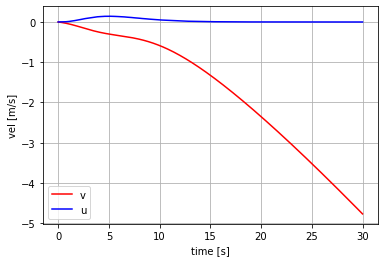

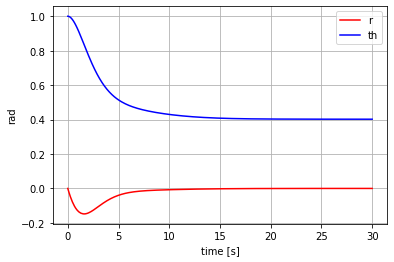

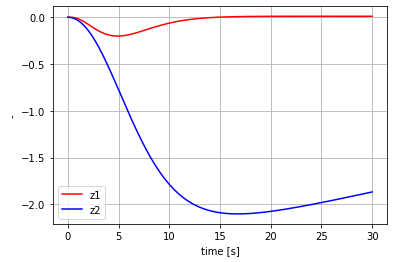

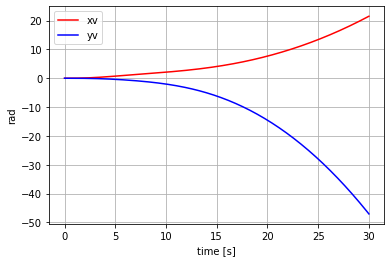

In [160]:
#wykres prędkości w lokalnym układzie sterowca
plt.figure()
plt.plot(t, v, 'r', label='v')
plt.plot(t, u, 'b', label='u')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('vel [m/s]')
plt.grid(True)
plt.show()
#wykres wykres prędkości kątowej r i kąta theta
plt.figure()
plt.plot(t, r, 'r', label='r')
plt.plot(t, th, 'b', label='th')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('rad')
plt.grid(True)
plt.show()
#wykres wykres z1 i z2
plt.figure()
plt.plot(t, z1, 'r', label='z1')
plt.plot(t, z2, 'b', label='z2')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('-')
plt.grid(True)
plt.show()
#wykres wykres z1 i z2
plt.figure()
plt.plot(t, xv, 'r', label='xv')
plt.plot(t, yv, 'b', label='yv')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('vel [m/s]')
plt.grid(True)
plt.show()